# Model training and predictions 
### Read from file and data cleaning

In [1]:
from pyspark.sql import SparkSession
spark  = SparkSession.builder.appName('App').config("spark.driver.memory", "14g").getOrCreate()

In [2]:
print(spark.sparkContext._conf.getAll())

[('spark.rdd.compress', 'True'), ('spark.app.name', 'App'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.submit.pyFiles', ''), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.app.id', 'local-1607753514944'), ('spark.driver.port', '49773'), ('spark.driver.memory', '14g'), ('spark.driver.host', 'kailundembp.hitronhub.home'), ('spark.ui.showConsoleProgress', 'true')]


In [3]:
""" NOTE: If prepared data exists, load it here: 
"""

test_df = spark.read.parquet("test_df_tag2")
test_df = test_df.repartition(16)
train_df = spark.read.parquet("train_df_tag2")
train_df = train_df.repartition(16)

In [2]:
# File location and type
file_location = "sample_comb2.csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
multiline = "true"
escape = "\""

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.csv(file_location,
                  inferSchema = infer_schema, 
                  sep = delimiter, 
                  header = first_row_is_header, 
                  multiLine = multiline, 
                  escape = escape)
df = df.repartition(16)

In [6]:
df.show()

+--------------------+--------------------+------------------+
|                Body|               Title|               tag|
+--------------------+--------------------+------------------+
|<p>My code looks ...|Ambiguous Overloa...|            string|
|<p>I'm getting</p...|Entity framework ...|entity-framework-4|
|<p>I disable a bu...|setEnabled Not wo...|       objective-c|
|<p>i have just do...|Oxite Blog Engine...|     asp.net-mvc-2|
|<p>Note - I have ...|Is the iPhone "cr...|              cron|
|<p>I have an issu...|How to send a ses...|              ajax|
|<p>Why are we usi...|Why are we using ...|             loops|
|<p>Can any one sh...|   C# and PostgreSQL|              .net|
|<p>I am building ...|A Binary choice b...|              .net|
|<p>I know multipl...|How do I loop the...|       objective-c|
|<p>The title sums...|How to build Goog...|     serialization|
|<p>I am developin...|No file creation/...|              file|
|<p>I want my face...|Is there a way to...|            

### Indexing tags in both test and train data sets

In [8]:
from pyspark.ml.feature import StringIndexer

#Encode tag's using String indexer

tag_idx = StringIndexer(inputCol='tag', outputCol = 'tag_idx')
tag_encode = tag_idx.fit(df)
df = tag_encode.transform(df)

In [8]:
df.count()

99831

### Split test/train sets

In [9]:
TRAINING_DATA_RATIO = 0.9
RANDOM_SEED = 1234

splits = [TRAINING_DATA_RATIO, 1.0 - TRAINING_DATA_RATIO]
training_data, test_data = df.randomSplit(splits, RANDOM_SEED)

In [10]:
print("Number of training set rows: %d" % training_data.count())
print("Number of test set rows: %d" % test_data.count())

Number of training set rows: 89911
Number of test set rows: 9920


# Preprocessing 

In [11]:
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_en = stopwords.words('english')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import RegexTokenizer

""" Helper functions for preprocessing. TODO: Consider wrapping into class below?
"""

@udf("String")
def lazy_prep_udf(c):
  """
  Clean noises from the string of text in given column

  Args:
    c - Column containing string of text

  Returns:
    Column with the cleaned string of text
  """
  df = BeautifulSoup(c)
  
  #noise
  urls = df.find_all('a')
  if urls != None:
    if len(urls)>0: 
      df.a.clear()
  
  return df.get_text().lower()

def tokenize(df, inputCol, outputCol):
  """
Split string of text in dataframe to word tokens.

Args:
  @param df Dataframe containing string of text
  @param inputCol name of input column containin the string of texts
  @param outputCol name of output column containin the word tokens
  
Returns:
  Dataframe containing the output column and the input column is dropped
"""
  tokenizer = RegexTokenizer(inputCol = inputCol, outputCol = outputCol, pattern=r"\s+") 
  df = tokenizer.transform(df).drop(inputCol)
  return df

def remove_punc(text):
  """Removes all punctuation marks from text.
  Args: 
    text (String): text column to convert 
  Returns:
    String.sql.Row: text w.o punctuation 
  """
  mod_punc = '!"$%&\'()*,-./:;<=>?@[\\]^_`{|}~'
  text = text.translate(str.maketrans(' ', ' ', mod_punc))
  return text.strip()


def remove_num(text):
  """Removes all numbers from text.
  Args: 
    text (String): text column to convert 
  Returns:
    String: text w.o numbers 
  """
  numbers="0123456789"
  text = text.translate(str.maketrans(' ', ' ', numbers))
  return text.strip()


  from nltk.tokenize import RegexpTokenizer 

@udf("String")
def trad_prep_udf(body):
  """Traditional body text preprocessing pieline. 
  Args: 
    text (pyspark.sql.Row): Text String to process
  Returns: 
    pyspark.sql.Row.ArrayType: cleaned tokens 
  """
  body = BeautifulSoup(body)
  stemmer = PorterStemmer()
  
  #noise
  urls = body.find_all('a')
  if len(urls)>0: 
    body.a.clear()
  
  text = body.get_text()
  
  words = []
  text = text.lower()

  tokenizer = RegexpTokenizer(r'\w+')
  # text = remove_punc(text)
  # text = remove_num(text)
  sents=tokenizer.tokenize(text)
  for sent in sents: 
    for word in nltk.word_tokenize(sent):
      if word in stop_en: continue
      # if len(word) < 3: continue
      words.append(stemmer.stem(word))
  return " ".join(words)


  """
Combine word tokens from title and body.

Args:
  df1 Dataframe containing Column with lists of stemmed word tokens from title
  inputCol1 name of the column containing lists of stemmed word tokens from title, cannot be same as inputCol2
  df2 Dataframe containing Column with lists of stemmed word tokens from body
  inputCol2 name of the column containing lists of stemmed word tokens from body, cannot be same as inputCol2
  outputCol column name of the ouput column containing the combined list of word tokens from title and body
"""
def combine_tokens(df, inputCol1, inputCol2, outputCol):
  result = df.withColumn(outputCol, concat(col(inputCol1), col(inputCol2)))
  return result

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kailunzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kailunzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
class Preprocessing:
  """Preprocessing stackoverflow question by remove html tags and tokenize words"""
  
  def __init__(self, df, titleCol, bodyCol):
    """
    Construct a Proprocessing object with attribute df: df cleans the text string in the given df using either lazy or traditional preprocessing
    """
    df = df.withColumn("Lazy_Title", lazy_prep_udf( df[titleCol] ) )
    df = df.withColumn("Lazy_Body", lazy_prep_udf( df[bodyCol] ) )
    df = df.withColumn("Trad_Title", trad_prep_udf( df[titleCol] ) )
    self.df = df.withColumn("Trad_Body", trad_prep_udf( df[bodyCol] ) )

  def get_token(self):
    self.df = tokenize(self.df, "Lazy_Title", 'Lazy_Title_Tokens')
    self.df = tokenize(self.df, "Lazy_Body", 'Lazy_Body_Tokens')
    self.df = tokenize(self.df, "Trad_Title", 'Trad_Title_Tokens')
    self.df = tokenize(self.df, "Trad_Body", 'Trad_Body_Tokens')
    return self.df

In [77]:
#Pre-processing the data
preProcessing = Preprocessing(df, "Title", "Body")
df_data = preProcessing.get_token()

In [78]:
from pyspark.sql.functions import desc, col

tag_counts = df.select('tag').groupby('tag').count().sort(desc('count'))
tag_counts.sort(col('count').desc()).show()

+--------------+-----+
|           tag|count|
+--------------+-----+
|        jquery| 3911|
|          .net| 2546|
|         mysql| 2388|
|       asp.net| 2021|
|          html| 1905|
|           css| 1765|
|   objective-c| 1758|
|           ios| 1691|
|       android| 1466|
|    javascript| 1153|
|        arrays| 1139|
|           sql| 1106|
|         regex| 1075|
|           xml|  991|
|          ruby|  967|
|    sql-server|  920|
|           wpf|  801|
|      database|  790|
|multithreading|  767|
|       windows|  762|
+--------------+-----+
only showing top 20 rows



In [79]:
body_counts = df_data.select('Trad_Body_Tokens').rdd.flatMap(lambda l : [(w,1) for w in l.Trad_Body_Tokens]).reduceByKey(lambda a,b: a+b).collect()
body_counts.sort(key=lambda tup: -tup[1])

In [80]:
display(body_counts[:10])

[('0', 99584),
 ('use', 96038),
 ('1', 93425),
 ('new', 56676),
 ('get', 55132),
 ('class', 54582),
 ('file', 53863),
 ('id', 52945),
 ('name', 50970),
 ('2', 49484)]

In [81]:
title_counts = df_data.select('Trad_Title_Tokens').rdd.flatMap(lambda l : [(w,1) for w in l.Trad_Title_Tokens]).reduceByKey(lambda a,b: a+b).collect()
title_counts.sort(key=lambda tup: -tup[1])

In [82]:
display(title_counts[:10])

[('use', 9969),
 ('file', 5649),
 ('c', 5208),
 ('get', 4318),
 ('jqueri', 4240),
 ('php', 4086),
 ('error', 3427),
 ('net', 3378),
 ('data', 3318),
 ('android', 3201)]

In [13]:
#Pre-processing the data
preProcessing = Preprocessing(test_data, "Title", "Body")
test_data = preProcessing.get_token()
preProcessing = Preprocessing(training_data, "Title", "Body")
training_data = preProcessing.get_token()


# Machine Learning Data Preparation

### Feature Engineering

In [14]:
from pyspark.ml.feature import CountVectorizer, IDF, NGram, VectorAssembler, StringIndexer, HashingTF
from pyspark.ml import Pipeline
def feature_engineer():
# FOR LAZY PRE-PROCESSING
  lazy_body_vector = CountVectorizer(inputCol = 'Lazy_Body_Tokens', outputCol = 'lazy_body_vector', minDF=0.01 , maxDF=0.85)
  lazy_title_vector = CountVectorizer(inputCol = 'Lazy_Title_Tokens', outputCol = 'lazy_title_vector', minDF=0.01 , maxDF=0.85)
  # FOR TRAD PRE-PROCESSING
  trad_body_vector = CountVectorizer(inputCol = 'Trad_Body_Tokens', outputCol = 'trad_body_vector', minDF=0.01 , maxDF=0.99)
  trad_title_vector = CountVectorizer(inputCol = 'Trad_Title_Tokens', outputCol = 'trad_title_vector', minDF=0.01 , maxDF=0.99)

  lazy_features = VectorAssembler(inputCols=['lazy_body_vector', 'lazy_title_vector'], outputCol='lazy_features')
  trad_features = VectorAssembler(inputCols=['trad_body_vector', 'trad_title_vector'], outputCol='trad_features')
  pipe = Pipeline(stages=[lazy_body_vector, lazy_title_vector, lazy_features, trad_body_vector, trad_title_vector, trad_features])
  pipe_model = pipe.fit(training_data)
  train_df = pipe_model.transform(training_data)  
  test_df = pipe_model.transform(test_data)
  return train_df, test_df

In [15]:
train_df, test_df = feature_engineer()

In [16]:
test_df.select("Trad_Body_Tokens", "trad_features", 'Body').show()

+--------------------+--------------------+--------------------+
|    Trad_Body_Tokens|       trad_features|                Body|
+--------------------+--------------------+--------------------+
|[possibl, duplic,...|(999,[1,3,12,14,2...|<blockquote>
  <p...|
|[possibl, duplic,...|(999,[1,14,26,30,...|<blockquote>
  <p...|
|[possibl, duplic,...|(999,[4,6,85,106,...|<blockquote>
  <p...|
|[pars, error, syn...|(999,[5,7,8,11,17...|<blockquote>
  <p...|
|[abstract, write,...|(999,[1,4,10,13,1...|<h3>Abstract</h3>...|
|[sum_, n, 1, inft...|(999,[0,1,2,42,43...|<p>$$\sum_{n=1}^\...|
|[1, see, panelgri...|(999,[2,5,9,13,20...|<p>1) I can see t...|
|[seem, work, norm...|(999,[1,10,14,15,...|<p><a href="http:...|
|[situat, insid, d...|(999,[0,1,3,14,20...|<p><a href="http:...|
|[mention, includ,...|(999,[31,65,70,76...|<p><a href="http:...|
|[io, app, contain...|(999,[0,4,7,9,10,...|<p><br>
My iOS ap...|
|[see, imag, attac...|(999,[1,15,20,28,...|<p><img src="http...|
|[descript, 2, sys...|(99

# Model Training

## Metrics helper

In [18]:
from pyspark.mllib.evaluation import MulticlassMetrics


def print_metrics(results_df, by_tag = False, ground_truth_col='tag_idx', prediction_col='prediction'):
    labels_and_predictions = results_df.select([ground_truth_col, prediction_col])
    # Instantiate metrics object
    metrics = MulticlassMetrics(labels_and_predictions.rdd)
    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

    if by_tag: 
        # Statistics by class
        labels = df.rdd.map(lambda lp: lp.tag_idx).distinct().collect()
        # print(labels)
        for label in sorted(labels):
            try:
                print("Class %s precision = %s" % (label, metrics.precision(label)))
                print("Class %s recall = %s" % (label, metrics.recall(label)))
                print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
            except: 
                print("Class %s not in this set!" % (label))

## Logistic Regression

**Hyperparameter Tuning**

In [19]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import IndexToString


lr = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx")

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0, 0.1, 1.0]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

lr_tvs = TrainValidationSplit(estimator=lr, 
                          estimatorParamMaps=paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='tag_idx'), 
                          trainRatio=0.9, 
                          seed=0
                         )

lr_grid_search = lr_tvs.fit(train_df)

In [20]:
print('Best Param (regParam): ', lr_grid_search.bestModel._java_obj.getRegParam())
print('Best Param (elasticNetParam): ', lr_grid_search.bestModel._java_obj.getElasticNetParam())
print('Best Param (fitIntercept): ', lr_grid_search.bestModel._java_obj.getFitIntercept())

Best Param (regParam):  0.0
Best Param (elasticNetParam):  0.0
Best Param (fitIntercept):  True


**Model training and transformation of test set**

In [ ]:
from pyspark.ml.classification import LogisticRegression
# Lazy model
# lr_lazy = LogisticRegression(featuresCol = "lazy_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0, regParam=0.01)
# lr_lazy_model = lr_lazy.fit(train_df)
# lr_lazy_results = lr_lazy_model.transform(test_df)

In [22]:
from pyspark.ml.classification import LogisticRegression
# Trad model
lr_trad = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx", fitIntercept=True, elasticNetParam=0.0, regParam=0.0)
lr_trad_model = lr_trad.fit(train_df)
lr_trad_results = lr_trad_model.transform(test_df)

**Performance Metrics**

In [25]:
# Trad Metrics
#lr_trad = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0.0, regParam=0)
print_metrics(lr_trad_results)

Summary Stats
Precision = 0.09954751131221719
Recall = 0.09649122807017543
F1 Score = 0.09799554565701557
Weighted recall = 0.18538306451612915
Weighted precision = 0.19485865722594883
Weighted F(1) Score = 0.18693310119681966
Weighted F(0.5) Score = 0.19091495662009184
Weighted false positive rate = 0.005670633008854041


In [26]:
# Trad Metrics
#lr_trad = LogisticRegression(featuresCol = "trad_features", labelCol = "tag_idx", fitIntercept=False, elasticNetParam=0.0, regParam=0.01)
#print_metrics(lr_trad_results)

Summary Stats
Precision = 0.09954751131221719
Recall = 0.09649122807017543
F1 Score = 0.09799554565701557
Weighted recall = 0.18538306451612915
Weighted precision = 0.19485865722594883
Weighted F(1) Score = 0.18693310119681966
Weighted F(0.5) Score = 0.19091495662009184
Weighted false positive rate = 0.005670633008854041


##Random Forest

**Model training and transformation of test set**

In [35]:
from pyspark.ml.classification import RandomForestClassifier
# Trad Model
# TODO: Select best hyper parameters
rf_trad = RandomForestClassifier(featuresCol = "trad_features", labelCol = "tag_idx", maxDepth=15, numTrees=15)
rf_trad_model = rf_trad.fit(train_df)
rf_trad_result = rf_trad_model.transform(test_df)

**Performance Metrics**

In [37]:
# Trad Metrics 15 x 15
from pyspark.mllib.evaluation import MulticlassMetrics

#Get labels/predictions in RDD expected by metrics classes
rf_trad_labels_and_predictions = rf_trad_result.select(["tag_idx", "prediction"])

# Instantiate metrics object
rf_trad_metrics = MulticlassMetrics(rf_trad_labels_and_predictions.rdd)

# Weighted stats
print("Weighted recall = %s" % rf_trad_metrics.weightedRecall)
print("Weighted precision = %s" % rf_trad_metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % rf_trad_metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % rf_trad_metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % rf_trad_metrics.weightedFalsePositiveRate)

Weighted recall = 0.18639112903225805
Weighted precision = 0.598517786217488
Weighted F(1) Score = 0.24704593349782364
Weighted F(0.5) Score = 0.339775643932226
Weighted false positive rate = 0.00862824210063521


# Results Analysis
As we can see from the above, the __ and __ model performed best on the lazy features and traditional features, respectively. We will now use the __ model to determine the highest performing and lowest performing classes.

In [38]:
# TODO: Update with best performing model 
top_df = rf_trad_result
top_df.show()

+--------------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                Body|               Title|                 tag|tag_idx|   Lazy_Title_Tokens|    Lazy_Body_Tokens|   Trad_Title_Tokens|    Trad_Body_Tokens|    lazy_body_vector|   lazy_title_vector|       lazy_features|    trad_body_vector|   trad_title_vector|       trad_features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----

In [40]:
# write prepared file for further use
top_df.write.parquet("top_df1")

In [7]:
top_df = spark.read.parquet("top_df1")
top_df.cache()
top_df.select(["tag", "tag_idx", "prediction"]).show()

+----------------+-------+----------+
|             tag|tag_idx|prediction|
+----------------+-------+----------+
|          jquery|    0.0|       0.0|
|      coldfusion|  331.0|       1.0|
|            .net|    1.0|       1.0|
|      javascript|    9.0|      20.0|
|           swing|   26.0|       1.0|
|          jquery|    0.0|       0.0|
|             sql|   11.0|       2.0|
|web-applications|  165.0|     344.0|
|   ruby-on-rails|   70.0|       2.0|
|      batch-file|  379.0|       1.0|
|           swing|   26.0|       1.0|
|web-applications|  165.0|      13.0|
|           mysql|    2.0|       2.0|
|          jquery|    0.0|       0.0|
|           regex|   12.0|       1.0|
|           shell|   76.0|       1.0|
|      networking|   47.0|       1.0|
|         android|    8.0|       8.0|
|         asp.net|    3.0|       3.0|
|entity-framework|   81.0|     407.0|
+----------------+-------+----------+
only showing top 20 rows



In [64]:
top_df.count()

19839

In [9]:
from pyspark.ml.feature import IndexToString
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer

#Encode tag's using String indexer
decoder = IndexToString(inputCol="prediction", outputCol="predicted_tag", labels=tag_encode.labels)
top_df = decoder.transform(top_df)
top_df.select(["tag", "tag_idx", "prediction", "predicted_tag"]).show()

+----------------+-------+----------+------------------+
|             tag|tag_idx|prediction|     predicted_tag|
+----------------+-------+----------+------------------+
|          jquery|    0.0|       0.0|            jquery|
|      coldfusion|  331.0|       1.0|              .net|
|            .net|    1.0|       1.0|              .net|
|      javascript|    9.0|      20.0|              ajax|
|           swing|   26.0|       1.0|              .net|
|          jquery|    0.0|       0.0|            jquery|
|             sql|   11.0|       2.0|             mysql|
|web-applications|  165.0|     344.0|        spring-mvc|
|   ruby-on-rails|   70.0|       2.0|             mysql|
|      batch-file|  379.0|       1.0|              .net|
|           swing|   26.0|       1.0|              .net|
|web-applications|  165.0|      13.0|               xml|
|           mysql|    2.0|       2.0|             mysql|
|          jquery|    0.0|       0.0|            jquery|
|           regex|   12.0|     

In [10]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd
from pyspark.sql.functions import desc, col

def get_label_metrics(results_df, ground_truth_col='tag_idx', prediction_col='prediction'):
    """Get pandas dataframe of top 10 tags with metrics from top_df

    Params: 
        results_df (pyspark DataFrame): top_df to get metrics of

    Returns:
        (pd.DataFrame): pandas dataframe in form of {column: [row_data]} for plotting
    """
    labels_and_predictions = results_df.select([ground_truth_col, prediction_col])
    # Instantiate metrics object
    metrics = MulticlassMetrics(labels_and_predictions.rdd)

    #get dict of labels to plot
    label_metrics = {}

    # Statistics by class
    labels = df.rdd.map(lambda lp: lp.tag_idx).distinct().collect()
    # print(labels)
    for label in sorted(labels):
        prec_recall_fMeasure = ()
        try:
            prec = metrics.precision(label)
            recall = metrics.recall(label)
            fMeasure = metrics.fMeasure(label, beta=1.0)
            prec_recall_fMeasure = (fMeasure, prec, recall) 
            label_metrics[label] = prec_recall_fMeasure
        except: 
            label_metrics[label] = (0,0,0)

    # get tags in string form: 
    tags = results_df.select(['tag', 'tag_idx']).distinct().collect()
    tag_pairs = {x['tag_idx']: x['tag'] for x in tags}

    # Convert tag classes into strings 
    tag_metrics = {}
    for tag_index in tag_pairs: 
        tag_metrics[tag_pairs[tag_index]] = label_metrics[tag_index]

    # Top 10 tags
    top_10_tags = sorted(tag_metrics, key=lambda x: tag_metrics[x][0], reverse=True)

    # Get overall tag counts from input DF
    tag_counts = train_df.select('tag').groupby('tag').count().sort(desc('count')).collect()
    tag_counts = {x['tag']: x['count'] for x in tag_counts}

    # Get ready for plotting
    plot_dict = {}
    tag_list = []
    f1_list = []
    precision_list = []
    recall_list = []
    tag_count_list = []

    for tag in top_10_tags:
        tag_list.append(tag)
        f1_list.append(tag_metrics[tag][0])
        precision_list.append(tag_metrics[tag][1])
        recall_list.append(tag_metrics[tag][2])
        tag_count_list.append(tag_counts[tag])

    plot_df = pd.DataFrame({"Tag": tag_list, "F1Measure": f1_list, "Precision":precision_list, "Recall":recall_list, "Count":tag_count_list})
    
    return plot_df

In [11]:
plot_df = get_label_metrics(top_df)
print(plot_df)

                Tag  F1Measure  Precision    Recall  Count
0             regex   0.561983   0.635514  0.503704   1008
1           eclipse   0.511364   0.681818  0.409091    589
2            arrays   0.491803   0.789474  0.357143    984
3    multithreading   0.435233   0.494118  0.388889    682
4               css   0.428571   0.600000  0.333333   1618
..              ...        ...        ...       ...    ...
495     performance   0.000000   0.000000  0.000000    470
496            mvvm   0.000000   0.000000  0.000000     84
497             wcf   0.000000   0.000000  0.000000    319
498        homework   0.000000   0.000000  0.000000    220
499          filter   0.000000   0.000000  0.000000     66

[500 rows x 5 columns]


In [23]:
plot_df[:10]

,Tag,F1Measure,Precision,Recall,Count
0,regex,0.561983,0.635514,0.503704,1008
1,eclipse,0.511364,0.681818,0.409091,589
2,arrays,0.491803,0.789474,0.357143,984
3,multithreading,0.435233,0.494118,0.388889,682
4,css,0.428571,0.600000,0.333333,1618
5,jquery,0.427696,0.828979,0.288192,3429
6,.htaccess,0.409091,0.310345,0.600000,261
7,xml,0.402332,0.741935,0.276000,983
8,facebook,0.395604,0.500000,0.327273,423
9,mysql,0.387164,0.782427,0.257221,2113


In [12]:
bottom_10 = plot_df.sort_values("Count").head(10)
print(bottom_10)

                        Tag  F1Measure  Precision  Recall  Count
291     windows-server-2003        0.0        0.0     0.0     38
395                workflow        0.0        0.0     0.0     38
121  multidimensional-array        0.0        0.0     0.0     39
458                triggers        0.0        0.0     0.0     39
431                download        0.0        0.0     0.0     40
407                     gps        0.0        0.0     0.0     41
445                  router        0.0        0.0     0.0     41
178               amazon-s3        0.0        0.0     0.0     42
468              namespaces        0.0        0.0     0.0     42
240                checkbox        0.0        0.0     0.0     43



Bad key "text.kerning_factor" on line 4 in
/Users/kailunzhang/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/Users/kailunzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


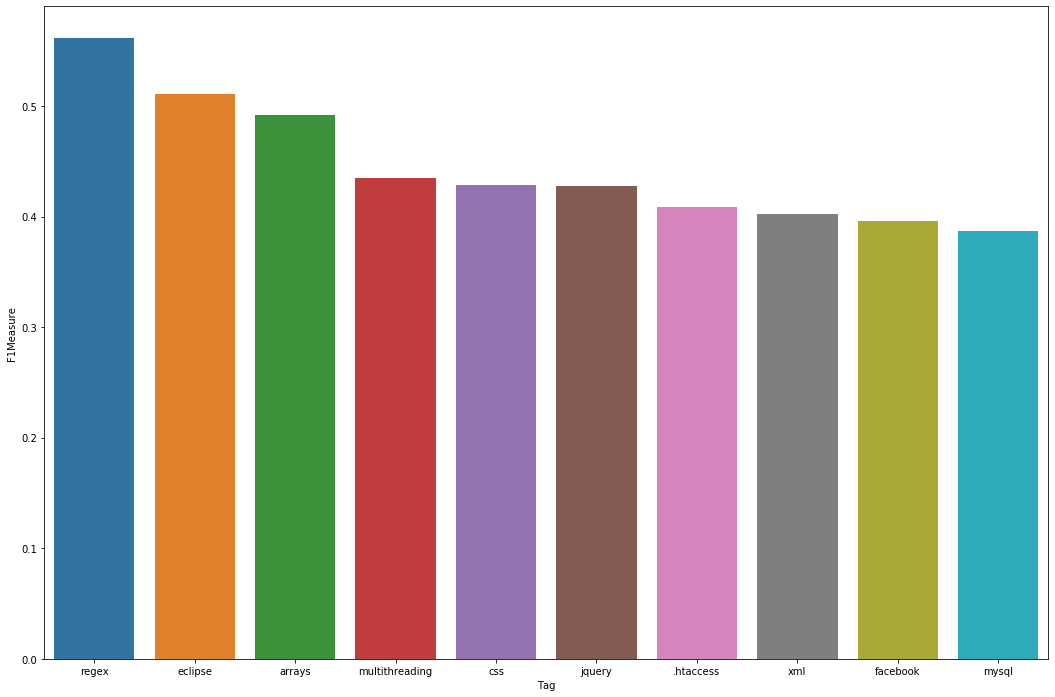

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="F1Measure", data=plot_df[:10], ax=ax)
fig.show()
# TODO: Update file name 
plt.savefig("Tag2_top10_f1")

/Users/kailunzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


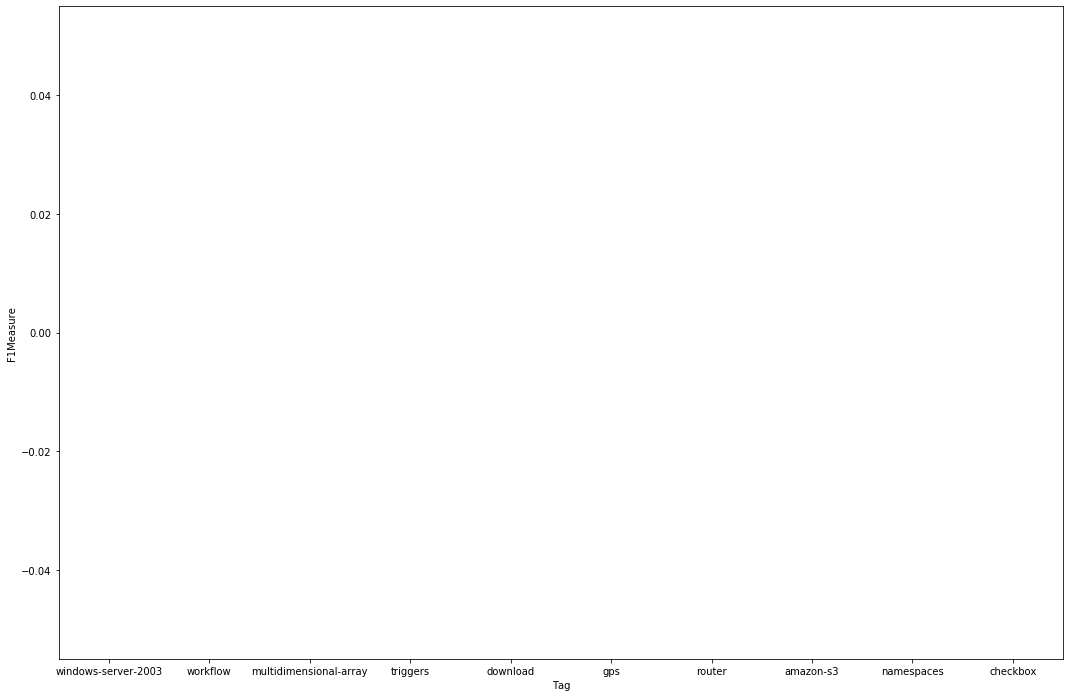

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="F1Measure", data=bottom_10, ax=ax)
fig.show()
plt.savefig("Tag2_bottom10_f1")

/Users/kailunzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


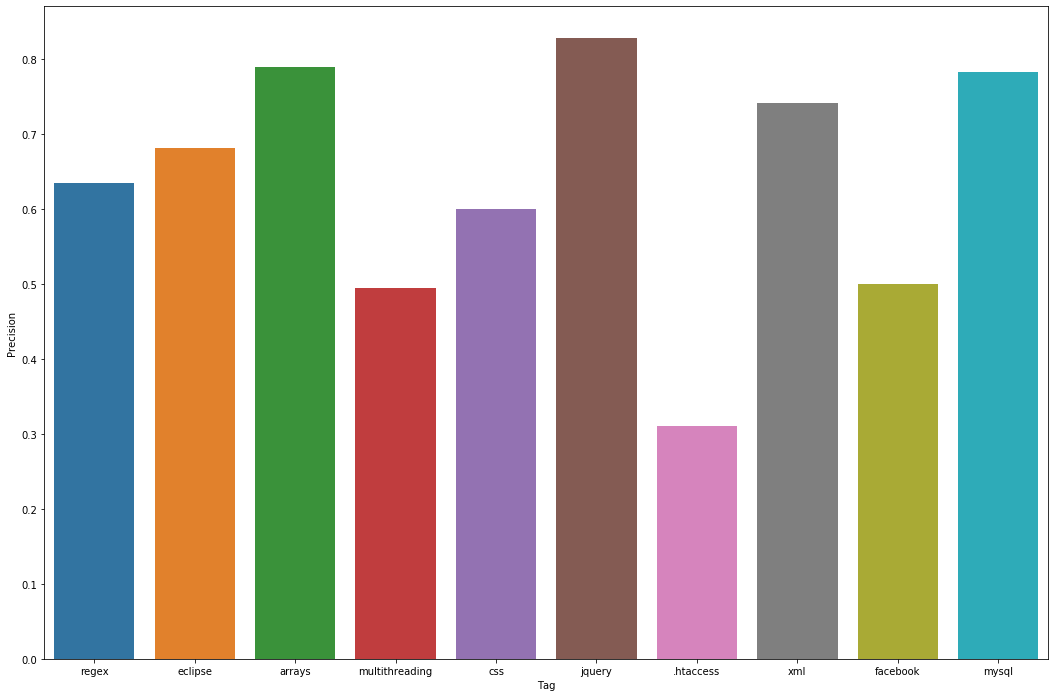

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Precision", data=plot_df[:10], ax=ax)
fig.show()
plt.savefig("Tag2_top10_prec")

/Users/kailunzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


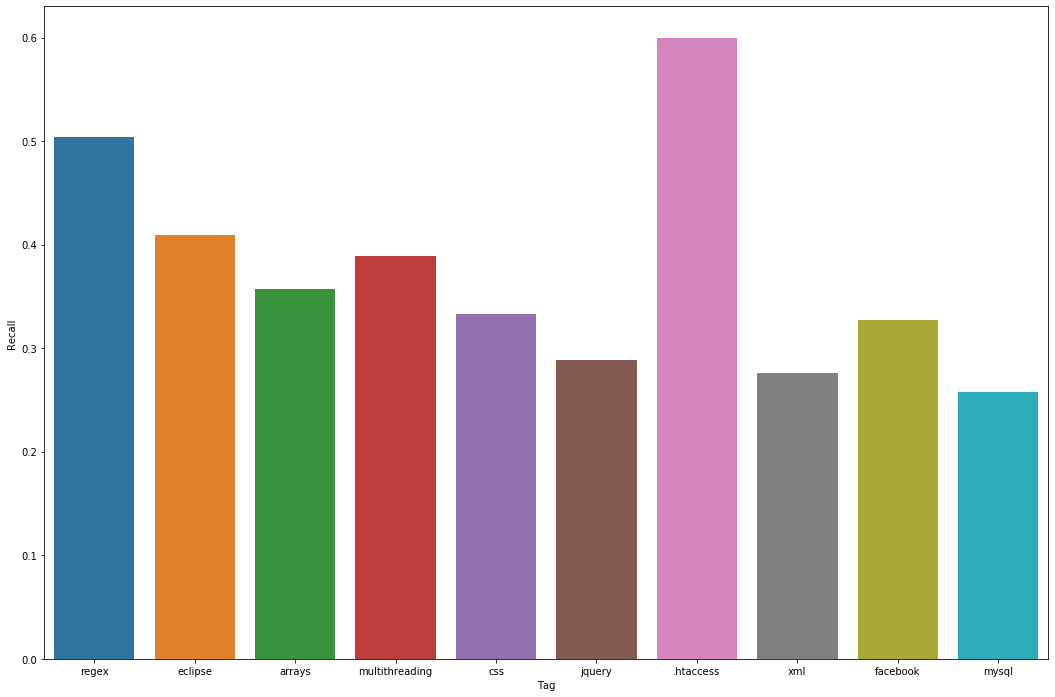

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Recall", data=plot_df[:10], ax=ax)
fig.show()
plt.savefig("Tag2_top10_recall")

/Users/kailunzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


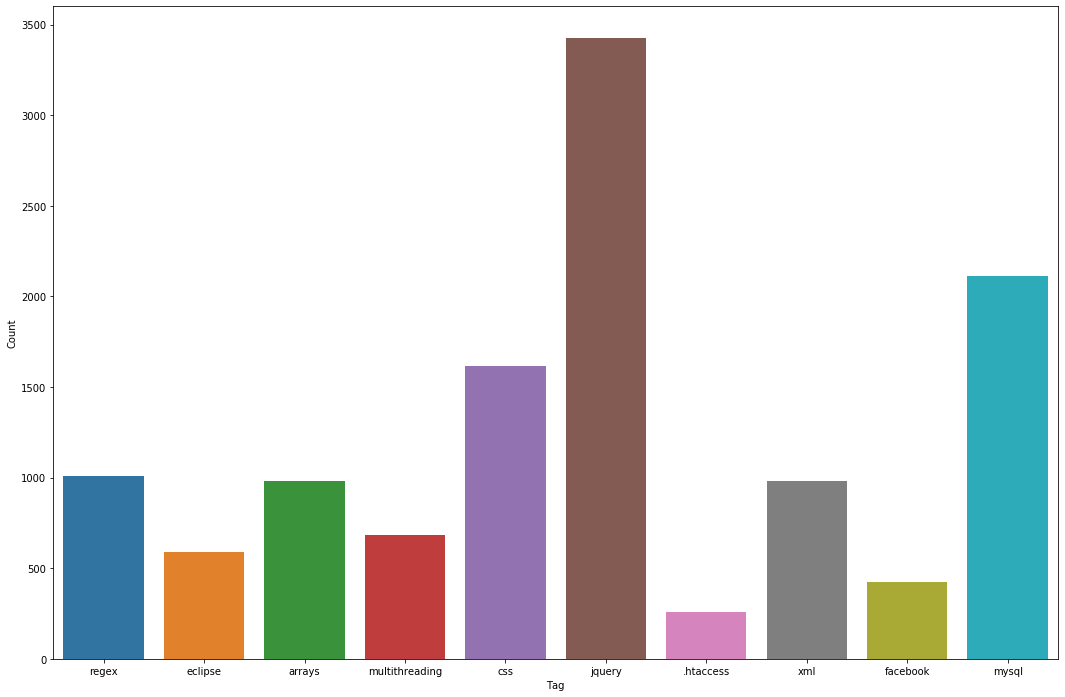

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Count", data=plot_df[:10], ax=ax)
fig.show()
plt.savefig("Tag2_top10_count")

/Users/kailunzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


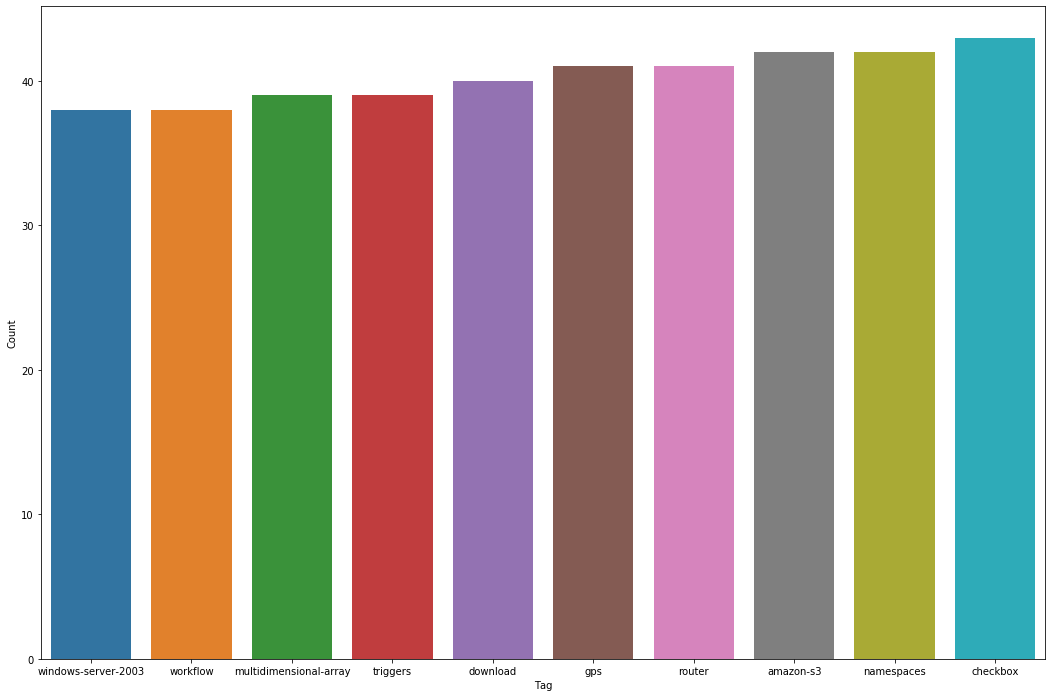

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.barplot(x="Tag", y="Count", data=bottom_10, ax=ax)
fig.show()
plt.savefig("Tag2_bottom10_count")

/Users/kailunzhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


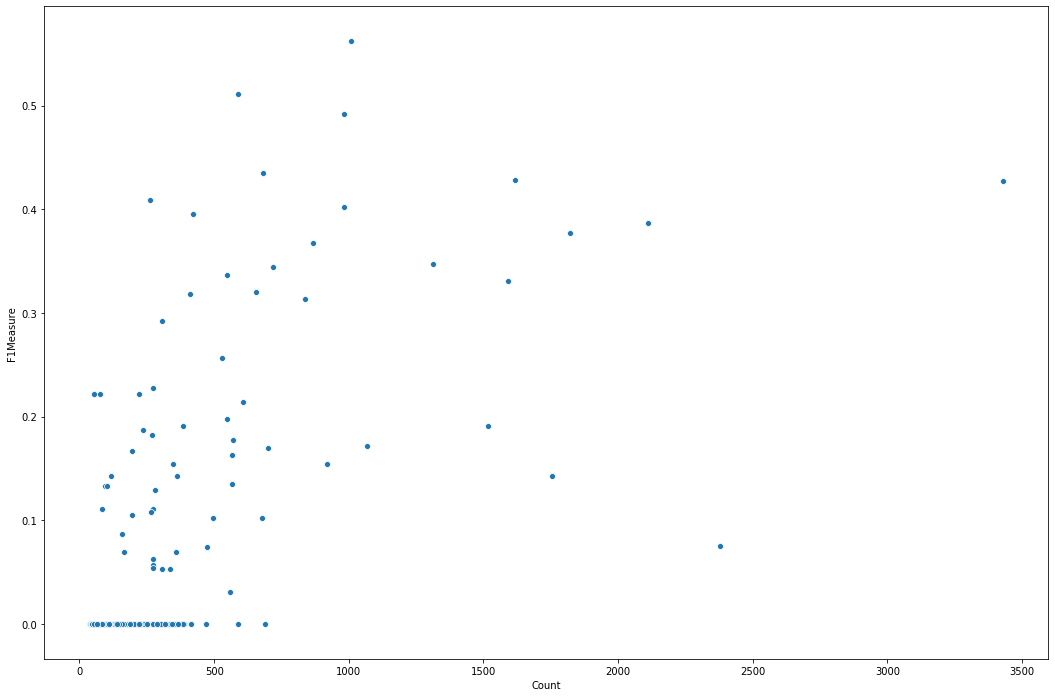

In [19]:
# Counts vs F1

import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[18,12])
sns.scatterplot(x="Count", y="F1Measure", data=plot_df, ax=ax)
fig.show()
plt.savefig("Tag 2 F1Measure vs Count")